# A Robust Peak Numbering Algorithm

## Problem description

Signal output of a Multi-Pixel Photon Counter (MPPC) is best seen by this scope screenshot provided by Hamamatsu.

![title](https://hub.hamamatsu.com/sp/hc/resources/TN0014/figure_1-14a.jpg)

The most conspicuous feature in the screenshot is that the amplitudes of signals are integral multiples of a unit amplitude. In this example, the green trace has an amplitude 2 times as large as that of the orange trace. If one integrates the area under the signals, the area values will concentrate at integral multiples of a certain area, forming peaks with a equal distance. Below is an example.

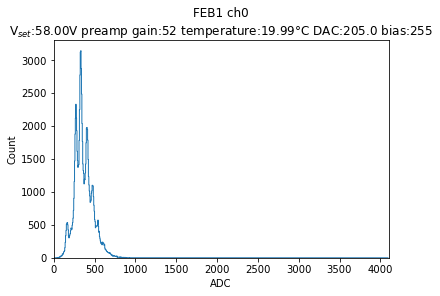

In [1]:
# my own modules
import os, sys
sys.path.insert(0, '../FEBDAQMULTx2/data_analysis/utilities')
import common_tools

bv58_thr205 = common_tools.MPPCLine('sample_data/robust_peak_numbering/20210301_124140_dark_rate_feb0_ch0_thr205.0.root',
                                    1,0,prom=100,pcb_half=0)
bv58_thr205.adc_spectrum()

### Trigger threshold
The data acquisition system is triggered whenever the signal is larger than a predefined level called threshold, or equivalently here, DAC. This DAC effectively is a minimum area. All events with an area smaller than this minimum area are simply ignore by the system. The effect on the ADC spectra is that there will be peaks on the low ADC side removed by the DAC. Below is an example of data taken with a high DAC value.

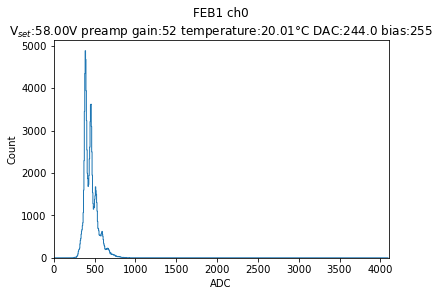

In [2]:
bv58_thr244 = common_tools.MPPCLine('sample_data/robust_peak_numbering/20210225_172920_mppc_volt58.0_thr244_gain52_temp20.0.root',
                                    1,0,prom=100,pcb_half=0)
bv58_thr244.adc_spectrum()

Obviously, several peaks on the left are removed by a higher DAC.
### Peak numbering convention
If the DAC is low enough, the first peak seen is the area under the baseline, or the pedestal peak. A number 0 is assigned to the pedestal peak. The equidistance peaks to the right are sequentially numbered 1, 2,... etc.
### The question
Given a dataset taken with an arbitrary threshold, determine the number of peaks removed by that threshold.
## Numbering peaks with auxiliary data
The gain, or the distance between peaks, has a linear relationship with the bias voltage applied to the MPPCs. Since a MPPC is diode, there is a breakdown voltage, beyond which a diode becomes conductive, and electrons undergo the avalanche effect, resulting in internal signal multiplication.

The gain is known to be proportional to the overvoltage, or the bias voltage less the breakdown voltage. To find the correct peak numbering for a certain bias voltage, one can seek help from data taken with different bias voltages. Since we know that peaks are equidistant, we can use certain peak finding algorithm to identify peak positions in ADC unit, and number the found peaks sequentially starting from 0. Below is an example of peak ADC vs peak number.

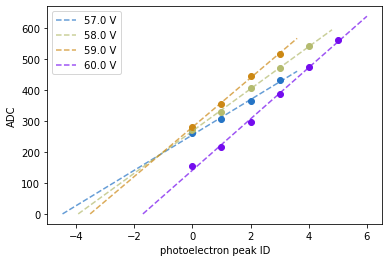

In [3]:
data_files = [
    'sample_data/robust_peak_numbering/20210301_112158_dark_rate_feb0_ch0_thr205.0.root',
    'sample_data/robust_peak_numbering/20210301_124140_dark_rate_feb0_ch0_thr205.0.root',
    'sample_data/robust_peak_numbering/20210301_142803_dark_rate_feb0_ch0_thr205.0.root',
    'sample_data/robust_peak_numbering/20210301_163042_dark_rate_feb0_ch0_thr205.0.root'
]

my_lines = common_tools.MPPCLines(data_files, 1, 0, prom=100, pcb_half=0)
my_lines.plot_line_group(my_lines.mppc_lines)

It's clearly seen that different bias voltages result in different slope, or equivalently, gain. Also note that if peaks are all numbered correctly, the lines should all originate from the same point at 0 peak ID.
### A first alsorithm to renumber peaks
A first simple idea can be something like this.
- For each line, shift it by some integral units to the left or right. Each combinations of the shifted lines form a *configuration*.
- For each configuration, take any two lines, and find their intersection point. All intersection points thus found form a point cloud.
- Take the average distance between any two points in the cloud. The configuration with the smallest average distance is the solution.

Let's see how this algorithm works.

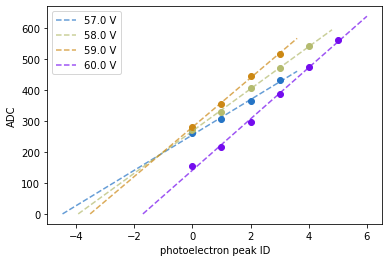

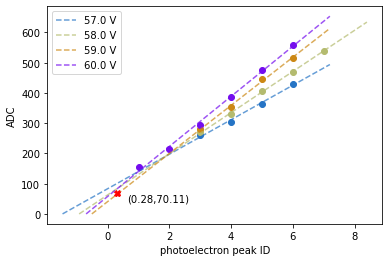

In [4]:
my_lines.enumerate_peaks()

The first plot is before the algorithm is executed, and the second one is after. The red cross is the centroid of the point cloud of intersection points. It does not have a 0 x-coordinate, so some guesswork has to be done. Besides, in certain datasets, this algorithm just gives the wrong answer (based on some educated guess).

A more robust algorithm is required.

## A formula linking peak ADC, photoelectron number (PE), and bias voltage
Since we know that the gain is proportional to overvoltage, we have

$$
\begin{align}
\frac{\Delta ADC}{\Delta PE} & \sim (V-V_{bd}) \\
\Rightarrow \frac{\Delta ADC}{\Delta PE} & = \beta (V-V_{bd})
\end{align}
$$
Integrate to get
$$
\boxed{ADC=\beta (V-V_{bd})PE+\gamma}
$$
Here, $\beta$ is the proportional constant, $V$ the bias voltage, $V_{bd}$ the breakdown voltage, and $\gamma$ a constant for pedestal ADC.

Of course, in the mathematical model, I have made the assumption that the pedestal ADC does not depend on the applied voltage, and this turns out to be a good approximation for peak numbering purpose.
### Visualize this function
We can visualize the ADC as a function of PE and bias voltage with $\beta=8$, $V_{bd}=52$, and $\gamma=180$.